# PROJECT OBJECTIVE:

## To predicted customers who would be particularly generous to Taxi Drivers (those who will tip 20% or more).

### For this project, consider the following questions:

1. What would be the ethical implications for this Model? 
2. What would be the consequences of the Model making errors?
3. What is the likely effect of the Model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't) or a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?
4. Do the benefits of such a model outweigh the potential problems?

Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happens often, drivers might not trust the app. Drivers are also very unlikely to pick up people who are predicted to not leave tips. 

Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.

It would not be good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.

- SOLUTION: We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,\
                            f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

# RUN THIS CELL TO SEE ALL COLUMNS 
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

Load the dataframe containing the Original data and Nyc_predict from the last project.

In [131]:
# Load original dataset into dataframe
df = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import Nyc_predict csv (Dataframe for predicted fares and mean distance and duration)
nyc_preds= pd.read_csv('nyc_predict.csv')

In [132]:
# Merge datasets
# Merge only useful columns from the original dataset with all the data from the nyc_predict dataset.
df0 = pd.concat([df[['payment_type','tpep_pickup_datetime','tpep_dropoff_datetime','RatecodeID','PULocationID','DOLocationID','tip_amount','total_amount']], nyc_preds], axis=1)
df0.head(2)

,payment_type,tpep_pickup_datetime,tpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,tip_amount,total_amount,VendorID,passenger_count,fare_amount,mean_distance,mean_duration,rush_hour
0,1,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,1,100,231,2.76,16.56,2,6,13.0,3.521667,22.847222,1
1,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,186,43,4.00,20.80,1,1,16.0,3.108889,24.470370,0


# FEATURE ENGINEERING

In [133]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   payment_type           22699 non-null  int64  
 1   tpep_pickup_datetime   22699 non-null  object 
 2   tpep_dropoff_datetime  22699 non-null  object 
 3   RatecodeID             22699 non-null  int64  
 4   PULocationID           22699 non-null  int64  
 5   DOLocationID           22699 non-null  int64  
 6   tip_amount             22699 non-null  float64
 7   total_amount           22699 non-null  float64
 8   VendorID               22699 non-null  int64  
 9   passenger_count        22699 non-null  int64  
 10  fare_amount            22699 non-null  float64
 11  mean_distance          22699 non-null  float64
 12  mean_duration          22699 non-null  float64
 13  rush_hour              22699 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 2.4+ 

From the previous EDA done on the last project, customers who pay cash generally have a tip amount of $0. To meet the modeling objective, We need to sample the data to select only the customers who pay with credit card.

In [134]:
df1 = df0.copy()

# Subset the data to isolate only customers who paid by credit card
df1 = df1[df1['payment_type']==1]

## FEATURE EXTRACTION AND TRANSFORMATION

In [135]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])

In [136]:
# Create a 'day'and'month' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
df1['month'] = df1['tpep_pickup_datetime'].dt.month_name().str.lower()

Create time of day columns\
Create four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

am_rush = [06:00–10:00)\
daytime = [10:00–16:00)\
pm_rush = [16:00–20:00)\
nighttime = [20:00–06:00)

Each new column should be identical and contain the same information using the hour (only) from the tpep_pickup_datetime column.

In [137]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

We'd need to write four functions to convert each new column to binary (0/1). 
Beginning with am_rush, write the function;

If the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [138]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

Now, apply the am_rush() function to the am_rush series to perform the conversion. Print the first three values of the column to make sure it did what you expected it to do.

Note: Be careful! If you run this cell twice, the function will be reapplied and the values will all be changed to 0.

In [139]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head(3)

0    1
1    0
2    1
Name: am_rush, dtype: int64

Write functions to convert the three remaining columns and apply them to their respective series.

In [140]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [141]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

In [142]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [143]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [144]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [145]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

Add a tip_percent column to the dataframe

In [146]:
# Create tip % col
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)
df1['tip_percent'].head(3)

0    0.200
1    0.238
2    0.199
Name: tip_percent, dtype: float64

Now create another column called generous. This will be the Target variable(y). The column should be a Binary indicator on whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [147]:
df1['generous'] = (df1['tip_percent'] >= 0.2).astype(int)
df1['generous'].head(3)

0    1
1    1
2    0
Name: generous, dtype: int32

In [148]:
df1.head()

,payment_type,tpep_pickup_datetime,tpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,tip_amount,total_amount,VendorID,passenger_count,fare_amount,mean_distance,mean_duration,rush_hour,day,month,am_rush,daytime,pm_rush,nighttime,tip_percent,generous
0,1,2017-03-25 08:55:43,2017-03-25 09:09:47,1,100,231,2.76,16.56,2,6,13.0,3.521667,22.847222,1,saturday,march,1,0,0,0,0.200,1
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,186,43,4.00,20.80,1,1,16.0,3.108889,24.470370,0,tuesday,april,0,1,0,0,0.238,1
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,262,236,1.45,8.75,1,1,6.5,0.881429,7.250000,1,friday,december,1,0,0,0,0.199,0
3,1,2017-05-07 13:17:59,2017-05-07 13:48:14,1,188,97,6.39,27.69,2,1,20.5,3.700000,30.250000,0,sunday,may,0,1,0,0,0.300,1
5,1,2017-03-25 20:34:11,2017-03-25 20:42:11,1,161,236,2.06,12.36,2,6,9.0,2.052258,11.855376,0,saturday,march,0,0,0,1,0.200,1


## FEATURE SELECTION

Drop redundant and irrelevant columns that would not be needed for the model when deployed. The target variable (generous) must remain in the data because it will get isolated as the y data for modeling.

In [149]:
df1.columns

Index(['payment_type', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'tip_amount',
       'total_amount', 'VendorID', 'passenger_count', 'fare_amount',
       'mean_distance', 'mean_duration', 'rush_hour', 'day', 'month',
       'am_rush', 'daytime', 'pm_rush', 'nighttime', 'tip_percent',
       'generous'],
      dtype='object')

In [150]:
# Drop columns
df2 = df1.copy()
drop_cols = ['payment_type', 'tpep_pickup_datetime', 'tpep_dropoff_datetime','tip_percent']
df2 = df2.drop(drop_cols, axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RatecodeID       15265 non-null  int64  
 1   PULocationID     15265 non-null  int64  
 2   DOLocationID     15265 non-null  int64  
 3   tip_amount       15265 non-null  float64
 4   total_amount     15265 non-null  float64
 5   VendorID         15265 non-null  int64  
 6   passenger_count  15265 non-null  int64  
 7   fare_amount      15265 non-null  float64
 8   mean_distance    15265 non-null  float64
 9   mean_duration    15265 non-null  float64
 10  rush_hour        15265 non-null  int64  
 11  day              15265 non-null  object 
 12  month            15265 non-null  object 
 13  am_rush          15265 non-null  int64  
 14  daytime          15265 non-null  int64  
 15  pm_rush          15265 non-null  int64  
 16  nighttime        15265 non-null  int64  
 17  generous         

Variable encoding\
Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as RatecodeID and the pickup and dropoff locations. To make these columns recognizable to the get_dummies() function as categorical variables, you'll first need to convert them to type(str).

Define a variable called cols_to_str, which is a list of the numeric columns that contain categorical information and must be converted to string. Then write a for loop that converts each column in cols_to_str to string.

In [151]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df2[col] = df2[col].astype('str')

Now convert all the categorical columns to binary using get_dummies().

In [152]:
# Convert categoricals to binary
df2 = pd.get_dummies(df2, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 350 entries, tip_amount to month_september
dtypes: bool(338), float64(5), int32(1), int64(6)
memory usage: 6.4 MB


Examine the class balance of your target variable.

In [153]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

Half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, let's consider the cost of both kinds of model error:

- False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
- False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more—even when the original customer would have tipped generously.

The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to infuriate customers. The metric should weigh both precision and recall equally.

- Which metric is this?\
F1 score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

# MODEL EVALUATION

In [154]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Modeling

In [155]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity,but you should assign a dictionary with ranges of values
cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'max_samples': [0.7],
             'n_estimators': [75, 100, 125, 150]
}
             

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the training data.\
Note: Depending on how many options you include in your search grid and the number of cross-validation folds you select, this could take a very long time—even hours. If you use 4-fold validation and include only one possible value for each hyperparameter and grow 300 trees to full depth, it should take about 5 minutes. If you add another value for GridSearch to check for, say, min_samples_split (so all hyperparameters now have 1 value except for min_samples_split, which has 2 possibilities), it would double the time to ~10 minutes. Each additional parameter would approximately double the time.

In [156]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 18min 19s
Wall time: 8h 32min


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [157]:
# Examine best score
rf.best_score_

0.8614233690252582

In [158]:
#Examine best hyperparameters
rf.best_params_

{'max_depth': None,
 'max_features': 4,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 150}

Use the make_results() function to output all of the scores of your model. Note that it accepts three arguments.

In [159]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [160]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.850773,0.872433,0.861423,0.852276


This is an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case.

Use pickle to save the models and read them back in. This can be particularly helpful when performing multiple ML algorithms to select the best parameter.

In [161]:
import pickle 

# Define a path to the folder where you want to save the model
path = (r'C:\Users\user\Desktop\VS CODE RELATED PROJECTS\AUTOMATIDATA PROJECT\Automatidata_Project_2.ipynb')

In [162]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [163]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Use the model to predict on the test data. Assign the results to a variable called rf_test_preds.

In [164]:
# Get scores on test data
rf_test_preds = rf.best_estimator_.predict(X_test)

In [165]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

Use the get_test_scores() function to generate the scores on the test data. Assign the results to rf_test_scores.\
Call rf_test_scores to output the results.

In [166]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_test_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.850773,0.872433,0.861423,0.852276
0,RF test,0.852439,0.869944,0.861103,0.852276


Compare Results of Random Forest Model with Xgboost model

In [167]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the X_train and y_train data.

In [168]:
%%time
xgb.fit(X_train, y_train)

CPU times: total: 1min 33s
Wall time: 26.8 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [169]:
# Examine best score
xgb.best_score_

0.9894995256505643

In [170]:
# Examine best parameters
xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

XGB CV results\
Use the make_results() function to output all of the scores of the model. Note that it accepts three arguments.

In [171]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB CV', xgb, 'f1')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.850773,0.872433,0.861423,0.852276
0,RF test,0.852439,0.869944,0.861103,0.852276
0,XGB CV,0.989277,0.989732,0.989500,0.988945


Use the model to predict on the test data. Assign the results to a variable called xgb_test_preds.

In [172]:
# Get scores on test data
xgb_test_preds = xgb.best_estimator_.predict(X_test)

XGB test results\
Use the get_test_scores() function to generate the scores on the test data. Assign the results to xgb_test_scores.
Call xgb_test_scores to output the results.

In [173]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.850773,0.872433,0.861423,0.852276
0,RF test,0.852439,0.869944,0.861103,0.852276
0,XGB CV,0.989277,0.989732,0.989500,0.988945
0,XGB test,0.994410,0.996266,0.995337,0.995087


 Both models are acceptable, but the xgb model is the champion.

Plot a confusion matrix of the champion model's predictions on the test data.

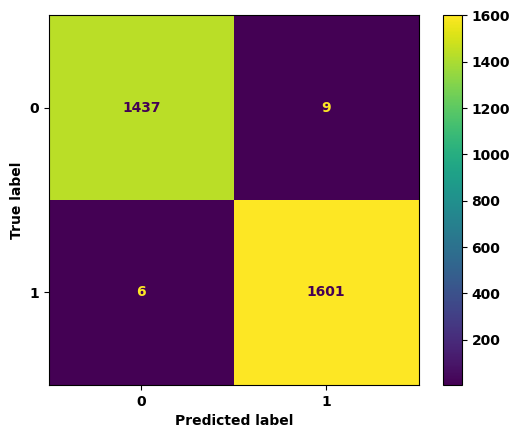

In [174]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb.classes_, 
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

Feature importance\
Use the feature_importances_ attribute of the best estimator object to inspect the features of the final model. You can then sort them and plot the most important ones.

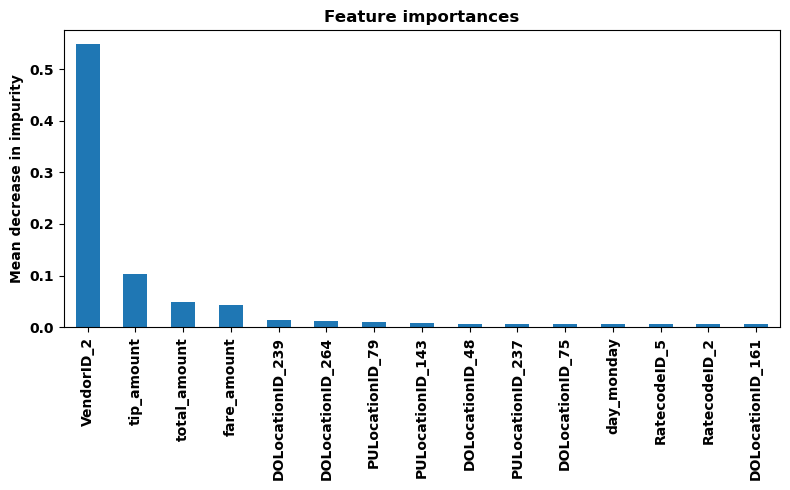

In [175]:
importances = xgb.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances, index=X_test.columns)
xgb_importances = xgb_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
xgb_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.show()

1. Would I recommend using this model? Why or why not?\
Yes, this model performs acceptably ok. Its F1 score was 0.995337 and it had an overall accuracy of 0.995087. It correctly identified ~99% of the actual responders in the test set, which is 50% better than a random guess. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.
2. How good is my highest scoring model and how can I explain its predictions?\
Unfortunately, XGBoost is not the most transparent machine learning algorithm. We know that VendorID, predicted_fare, mean_duration, and mean_distance are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that VendorID is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.
3. What features would I want to have that would likely improve the performance of the model?\
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash. It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.
